<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>
<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>
<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: Otimização dos Parâmetros de Análise Técnica utilizando Bandas de Bollinger para Operações com BitCoin<br>
ALUNA:&nbsp;&nbsp;Bruna Graziela Martins Nunes</h3>

<p>Este notebook é referente ao Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. Para o desenvolvimento deste trabalho foi utilizada a API Pandas DataReader para geração dos datasets. Esta API carrega os dados negociação do Yahoo Finance.</p>

<p>Começamos importando as bibliotecas necessárias para a execução do modelo:</p>

In [17]:
# Bibliotecas gerais
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import statistics

# API para carregar dados do Yahoo Finance
import pandas_datareader as pdr

# Sci-kit learn
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

Carregamento dos dados do Bitcoin negociado em dólares americanos (USD) da API Yahoo Finance utilizando pandas_datareader. Os dados começam em Setembro de 2014.

                  High         Low        Open       Close      Volume  \
Date                                                                     
2014-09-16  468.174011  452.421997  465.864014  457.334015  21056800.0   
2014-09-17  456.859985  413.104004  456.859985  424.440002  34483200.0   
2014-09-18  427.834991  384.532013  424.102997  394.795990  37919700.0   
2014-09-19  423.295990  389.882996  394.673004  408.903992  36863600.0   
2014-09-20  412.425995  393.181000  408.084991  398.821014  26580100.0   

             Adj Close  
Date                    
2014-09-16  457.334015  
2014-09-17  424.440002  
2014-09-18  394.795990  
2014-09-19  408.903992  
2014-09-20  398.821014  


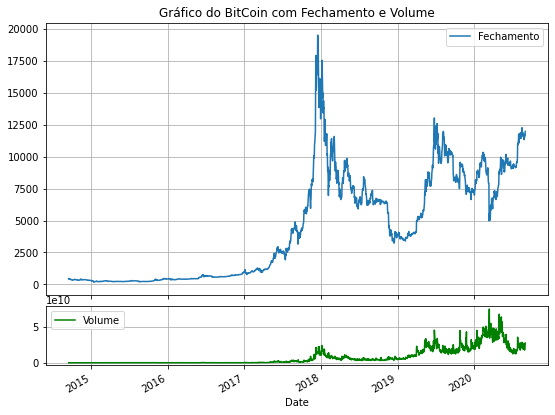

In [18]:
df = pdr.DataReader("BTC-USD", "yahoo", "2010-01-01", "2020-08-31")
print(df.head())

plt.figure(figsize=(9, 7))
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)
df["Close"].plot(label="Fechamento")
ax.set_xticklabels([])
ax.set_xlabel("")

plt.title("Gráfico do BitCoin com Fechamento e Volume")
plt.grid()
plt.legend()

plt.subplot2grid((5, 1), (4, 0))

df["Volume"].plot(label="Volume",color="green")
plt.grid()
plt.legend()
plt.show()




Comparação com o volume de negociação de outros índices e ações:

   Ação  Volume Último Dia  Volume Médio dos Últimos 30 Dias
0  AAPL       2.912467e+10                      2.062448e+10
1  AMZN       5.085584e+09                      6.730202e+09
2  BVSP       4.029506e+10                      3.368013e+10
3   BTC       2.731156e+10                      2.294543e+10


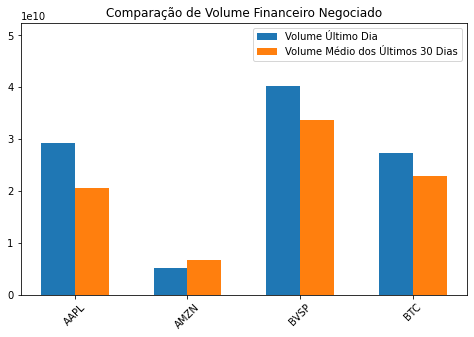

In [19]:
AAPL   = pdr.DataReader("AAPL", "yahoo", df.index[0], df.index[-1])
AMZN   = pdr.DataReader("FB", "yahoo", df.index[0], df.index[-1])
BVSP   = pdr.DataReader("^BVSP", "yahoo", df.index[0], df.index[-1])
BRLUSD = pdr.DataReader("BRL=X", "yahoo", df.index[0], df.index[-1])

AAPL["Volume"] = AAPL["Volume"] * AAPL["Close"] # Converte o volume em USD
AMZN["Volume"] = AMZN["Volume"] * AMZN["Close"] # Converte o volume em USD
BVSP["Close"]  = BVSP["Close"] / BRLUSD["Close"] # Converte o fechamento em USD
BVSP["Volume"] = BVSP["Volume"] / BRLUSD["Close"] * BVSP["Close"] # Converte o volume em USD

BVSP = BVSP.dropna()

volumes = pd.DataFrame({
    "Ação": [
        "AAPL", 
        "AMZN",
        "BVSP",
        "BTC",
    ],
    "Volume Último Dia": [
        AAPL["Volume"][-1],
        AMZN["Volume"][-1],
        BVSP["Volume"][-1],
        df["Volume"][-1],
    ],
    "Volume Médio dos Últimos 30 Dias": [
        AAPL["Volume"].rolling(30).mean()[-1], 
        AMZN["Volume"].rolling(30).mean()[-1],
        BVSP["Volume"].rolling(30).mean()[-1],
        df["Volume"].rolling(30).mean()[-1],
    ],
})

print(volumes)

x  = np.arange(len(volumes))
_, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.bar(x - 0.15, volumes["Volume Último Dia"], 0.3, label="Volume Último Dia")
ax.bar(x + 0.15, volumes["Volume Médio dos Últimos 30 Dias"], 0.3, label="Volume Médio dos Últimos 30 Dias")
ax.set_ylim([0, max(volumes["Volume Último Dia"].values) * 1.3])
ax.set_xticks(x)
ax.set_xticklabels(volumes["Ação"])
plt.title("Comparação de Volume Financeiro Negociado")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Configurações iniciais do modelo:

In [20]:

# Restringe o modelo ao período com maior volume de negociação
df = df[df.index >= datetime.datetime(2017, 9, 1)]

colunas_entrada    = ["Close"]
colunas_saida      = ["STD", "MA"]
passos_minimos     = 30
tamanho_teste      = 365
valores_STD        = [0] * passos_minimos
valores_MA         = [0] * passos_minimos
valores_fechamento = df["Close"].values
valores_abertura   = df["Open"].values
valores_minima     = df["Low"].values
valores_maxima     = df["High"].values
tamanho_total      = len(df)
lista_STD          = np.arange(1.5, 3, 0.5)
lista_MA           = list(range(8, passos_minimos, 2))

Cálculo dos dados para as Bandas de Bollinger:

In [21]:
for i in range(passos_minimos, tamanho_total):
    melhor = (-999999, )

    for MA in lista_MA:
        rolagem   = df["Close"].rolling(MA)
        atual_MA  = rolagem.mean()
        atual_STD = rolagem.std()
        
        for STD in lista_STD:
            atual_BB_CIMA   = atual_MA + atual_STD * STD
            atual_BB_BAIXO  = atual_MA - atual_STD * STD
            atual_resultado = 0

            for j in range(i, min(tamanho_total, i + passos_minimos)):
                atual_stop_loss = atual_STD[j] * STD
                
                if valores_fechamento[j - 1] < atual_BB_BAIXO[j - 1] and valores_fechamento[j] > atual_BB_BAIXO[j] and valores_fechamento[j] > valores_abertura[j]:
                    if valores_fechamento[j] - valores_minima[j + 1] > atual_stop_loss:
                        atual_resultado += -atual_stop_loss
                    else:
                        atual_resultado += valores_fechamento[j + 1] - valores_fechamento[j]
                elif valores_fechamento[j - 1] > atual_BB_CIMA[j - 1] and valores_fechamento[j] < atual_BB_CIMA[j] and valores_fechamento[j] < valores_abertura[j]:
                    if valores_maxima[j + 1] - valores_fechamento[j] > atual_stop_loss:
                        atual_resultado += -atual_stop_loss
                    else:
                        atual_resultado += valores_fechamento[j] - valores_fechamento[j + 1]

            if atual_resultado > melhor[0]:
                melhor = (atual_resultado, STD, MA)

    valores_STD.append(melhor[1])
    valores_MA.append(melhor[2])

df["STD"] = valores_STD
df["MA"]  = valores_MA

Gráfico com os parâmetros do modelo:

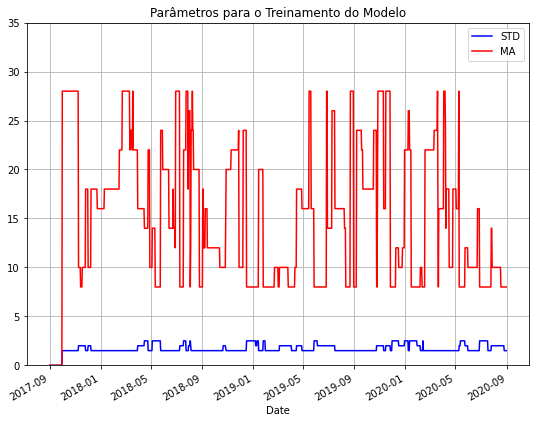

In [22]:
plt.figure(figsize=(9, 7))
df["STD"].plot(label="STD",color="blue")
df["MA"].plot(label="MA",color="red")

plt.gca().set_ylim([0, passos_minimos + 5])
plt.title("Parâmetros para o Treinamento do Modelo")
plt.grid()
plt.legend()
plt.show()

Prepara os dados de treino e teste:

In [23]:
# Dados de treino
tamanho_treino = len(df) - tamanho_teste
x_dados_treino = df[:tamanho_treino][colunas_entrada].values
y_dados_treino = df[:tamanho_treino][colunas_saida].values
x_treino       = []
y_treino       = []

for i in range(passos_minimos, tamanho_treino):
    x_treino.append(x_dados_treino[i-passos_minimos:i])
    y_treino.append(y_dados_treino[i])

x_treino, y_treino = np.array(x_treino), np.array(y_treino)
x_treino = np.reshape(x_treino, (len(x_treino), passos_minimos * len(colunas_entrada)))

# Dados de teste
x_dados_teste = df[tamanho_treino - passos_minimos:][colunas_entrada].values
y_dados_teste = df[tamanho_treino - passos_minimos:][colunas_saida].values
x_teste       = []
y_teste       = []

for i in range(passos_minimos, tamanho_total - tamanho_treino + passos_minimos):
    x_teste.append(x_dados_teste[i-passos_minimos:i])
    y_teste.append(y_dados_teste[i])

x_teste, y_teste = np.array(x_teste), np.array(y_teste)
x_teste = np.reshape(x_teste, (len(x_teste), passos_minimos * len(colunas_entrada)))

print(f"Tamanho dos dados de treino: {len(x_treino)}")
print(f"Tamanho dos dados de teste: {len(x_teste)}")

Tamanho dos dados de treino: 700
Tamanho dos dados de teste: 365


Efetua o treinamento do modelo de classificação:

In [24]:
x_completo = np.concatenate([x_treino, x_teste])
melhores   = [[0]] * len(colunas_saida)
acuracias  = []

modelos = [
    LogisticRegression(random_state=7),
    DecisionTreeClassifier(random_state=7),
    MultinomialNB(),
    GradientBoostingClassifier(random_state=7),
    MLPClassifier(random_state=7)
]

for i, coluna in enumerate(colunas_saida):
    encoder_atual  = LabelEncoder().fit(lista_STD if coluna == "STD" else lista_MA)
    y_treino_atual = encoder_atual.transform([x[i] for x in y_treino])
    y_teste_atual  = encoder_atual.transform([x[i] for x in np.concatenate([y_treino, y_teste])])

    for modelo in modelos:
        modelo.fit(x_treino, y_treino_atual)
        predicoes = modelo.predict(x_completo)

        acuracia = accuracy_score(y_teste_atual, predicoes)
        print(f"Acurácia para {coluna} no modelo {modelo}: {acuracia:.2%}")

        acuracias.append(dict(
            acuracia=acuracia,
            coluna=coluna,
            modelo=re.sub(r'\(.*$', '', str(modelo))
        ))

        if acuracia > melhores[i][0]:
            melhores[i] = [acuracia, modelo, predicoes, encoder_atual]

Acurácia para STD no modelo LogisticRegression(random_state=7): 63.47%
Acurácia para STD no modelo DecisionTreeClassifier(random_state=7): 82.44%
Acurácia para STD no modelo MultinomialNB(): 52.39%
Acurácia para STD no modelo GradientBoostingClassifier(random_state=7): 84.23%
Acurácia para STD no modelo MLPClassifier(random_state=7): 49.39%
Acurácia para MA no modelo LogisticRegression(random_state=7): 27.32%
Acurácia para MA no modelo DecisionTreeClassifier(random_state=7): 71.64%
Acurácia para MA no modelo MultinomialNB(): 12.86%
Acurácia para MA no modelo GradientBoostingClassifier(random_state=7): 73.05%
Acurácia para MA no modelo MLPClassifier(random_state=7): 19.53%


Heatmap dos modelos testados:

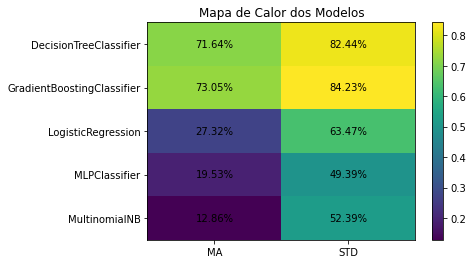

In [25]:
df_acuracias = pd.DataFrame(acuracias)
df_acuracias = pd.crosstab(df_acuracias.modelo, df_acuracias.coluna, values=df_acuracias.acuracia, aggfunc="mean")

hm_modelos = df_acuracias.index.values
hm_colunas = df_acuracias.columns

fig, ax = plt.subplots(1, 1)
im = ax.imshow(df_acuracias, aspect="auto")

for x, coluna in enumerate(hm_colunas):
    for y, modelo in enumerate(hm_modelos):
        ax.text(x, y, f"{df_acuracias.loc[modelo][coluna]:.2%}", ha="center", va="center", color="black")

ax.set_yticks(np.arange(len(hm_modelos)))
ax.set_yticklabels(hm_modelos)
ax.set_xticks(np.arange(len(hm_colunas)))
ax.set_xticklabels(hm_colunas)

plt.title("Mapa de Calor dos Modelos")
plt.colorbar(im)
plt.show()

Simulação das operações e apuração dos resultados:

In [26]:
valores_STD      = []
valores_MA       = []
valores_BB_CIMA  = []
valores_BB_BAIXO = []
operacoes        = [0] * (tamanho_total)
operacoes_compra = [0] * (tamanho_total)
operacoes_venda  = [0] * (tamanho_total)
predicoes_STD    = melhores[0][3].inverse_transform(melhores[0][2])
predicoes_MA     = melhores[1][3].inverse_transform(melhores[1][2])

for i in range(tamanho_treino, tamanho_total, passos_minimos):
    STD = predicoes_STD[i-passos_minimos]
    MA  = predicoes_MA[i-passos_minimos]

    rolagem         = df["Close"].rolling(int(MA))
    atual_MA        = rolagem.mean()
    atual_STD       = rolagem.std()
    atual_BB_CIMA   = atual_MA + atual_STD * STD
    atual_BB_BAIXO  = atual_MA - atual_STD * STD

    for j in range(i, min(tamanho_total, i + passos_minimos)):
        atual_stop_loss = atual_STD[j] * STD

        if valores_fechamento[j - 1] < atual_BB_BAIXO[j - 1] and valores_fechamento[j] > atual_BB_BAIXO[j] and valores_fechamento[j] > valores_abertura[j]:
            if valores_fechamento[j] - valores_minima[j + 1] > atual_stop_loss:
                operacoes[j] = -atual_stop_loss
            else:
                operacoes[j] = valores_fechamento[j + 1] - valores_fechamento[j]

            operacoes_compra[j] = operacoes[j]
        elif valores_fechamento[j - 1] > atual_BB_CIMA[j - 1] and valores_fechamento[j] < atual_BB_CIMA[j] and valores_fechamento[j] < valores_abertura[j]:
            if valores_maxima[j + 1] - valores_fechamento[j] > atual_stop_loss:
                operacoes[j] = -atual_stop_loss
            else:
                operacoes[j] = valores_fechamento[j] - valores_fechamento[j + 1]

            operacoes_venda[j] = operacoes[j]

        valores_STD.append(atual_STD[j])
        valores_MA.append(atual_MA[j])
        valores_BB_CIMA.append(atual_BB_CIMA[j])
        valores_BB_BAIXO.append(atual_BB_BAIXO[j])

operacoes        = np.array(operacoes)
operacoes_compra = np.array(operacoes_compra)
operacoes_venda  = np.array(operacoes_venda)
acumulado        = np.cumsum(operacoes)
pico             = np.argmin(np.minimum.accumulate(acumulado) - acumulado)
maior_ganho      = acumulado[pico] - acumulado[np.argmin(acumulado[pico:])]
vale             = np.argmax(np.maximum.accumulate(acumulado) - acumulado)
maior_perda      = acumulado[vale] - acumulado[np.argmax(acumulado[:vale])]

contagem   = len(operacoes[operacoes != 0.])
ganhos     = len(operacoes[operacoes > 0.])
perdas     = len(operacoes[operacoes < 0.])
resultado  = np.sum(operacoes)
taxa_ganho = round(0 if contagem == 0 else ganhos/contagem, 1)

print("Modelo STD: {}".format(melhores[0][1]))
print("Modelo MA: {}".format(melhores[1][1]))
print("Total de operações: {}".format(contagem))
print("Uma operação a cada {:.1f} dias".format(tamanho_teste/contagem))
print("Operações com ganho: {}".format(ganhos))
print("Operações com perda: {}".format(perdas))
print("Taxa de ganho: {:.2%}".format(taxa_ganho))
print("Melhor ganho: {}".format(max(operacoes[operacoes > 0.])))
print("Ganho médio: {}".format(statistics.mean(operacoes[operacoes > 0.])))
print("Maior ganho acumulado: {}".format(maior_ganho))
print("Pior perda: {}".format(min(operacoes[operacoes < 0.])))
print("Perda média: {}".format(statistics.mean(operacoes[operacoes < 0.])))
print("Maior perda acumulada: {}".format(maior_perda))
print("Resultado total: {}".format(resultado))

Modelo STD: GradientBoostingClassifier(random_state=7)
Modelo MA: GradientBoostingClassifier(random_state=7)
Total de operações: 25
Uma operação a cada 14.6 dias
Operações com ganho: 11
Operações com perda: 14
Taxa de ganho: 40.00%
Melhor ganho: 837.4658203125
Ganho médio: 306.6155894886364
Maior ganho acumulado: 1269.0623629468912
Pior perda: -363.3408203125
Perda média: -179.43811319816618
Maior perda acumulada: -1227.32373046875
Resultado total: 860.6378996006737


Gráfico do ativo e das operações:

DatetimeIndex(['2019-10-30', '2020-03-07', '2020-03-21', '2020-04-09',
               '2020-05-08', '2020-08-17'],
              dtype='datetime64[ns]', name='Date', freq=None)


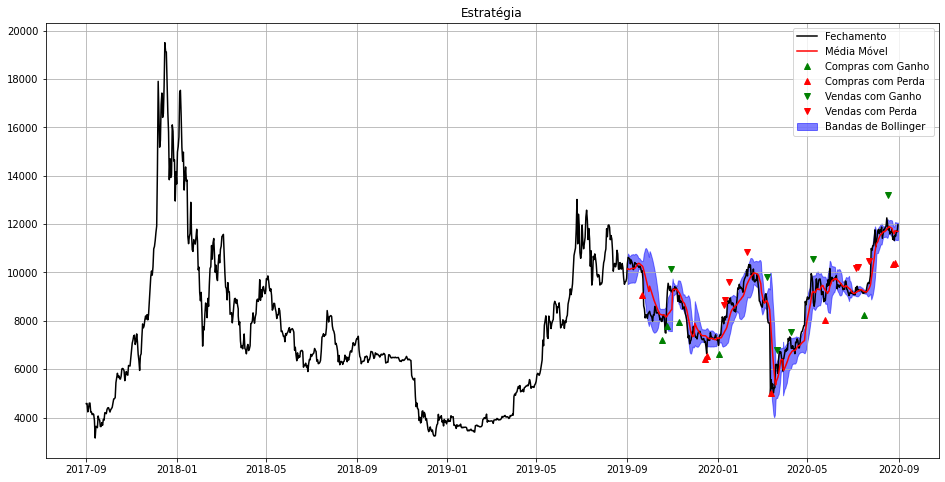

In [27]:
plt.figure(figsize=(16, 8))

print(df.loc[operacoes_venda > 0].index)

plt.plot(df.index, valores_fechamento, color='black', label='Fechamento')
plt.plot(df.iloc[tamanho_treino:].index, valores_MA, color='red', label='Média Móvel')
plt.plot(df.loc[operacoes_compra > 0].index, valores_fechamento[operacoes_compra > 0] * .9, '^', color='green', label='Compras com Ganho')
plt.plot(df.loc[operacoes_compra < 0].index, valores_fechamento[operacoes_compra < 0] * .9, '^', color='red', label='Compras com Perda')
plt.plot(df.loc[operacoes_venda > 0].index, valores_fechamento[operacoes_venda > 0] * 1.1, 'v', color='green', label='Vendas com Ganho')
plt.plot(df.loc[operacoes_venda < 0].index, valores_fechamento[operacoes_venda < 0] * 1.1, 'v', color='red', label='Vendas com Perda')
plt.fill_between(df.iloc[tamanho_treino:].index, valores_BB_BAIXO, valores_BB_CIMA, color='blue', alpha=0.5, label='Bandas de Bollinger')

plt.title("Estratégia")
plt.legend()
plt.grid()
plt.show()

Gráfico do ativo e das operações somente para o período de teste:

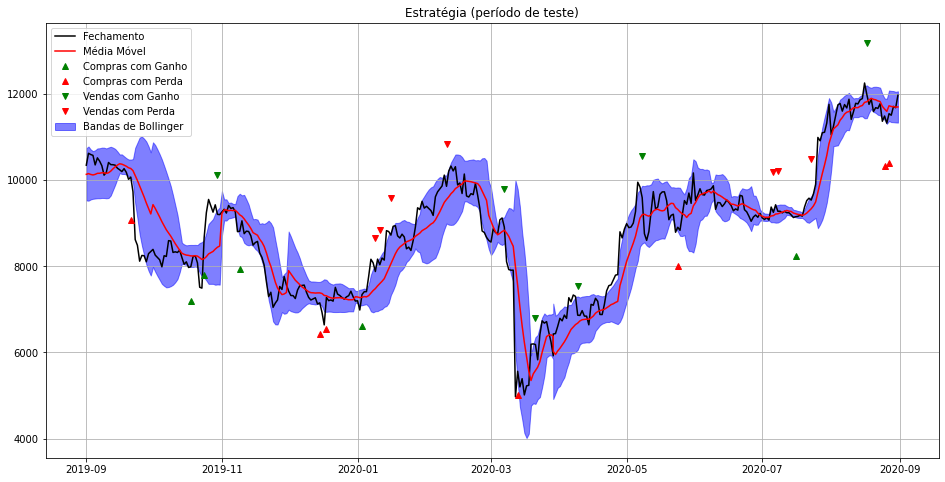

In [28]:
plt.figure(figsize=(16, 8))

plt.plot(df.iloc[tamanho_treino:].index, valores_fechamento[tamanho_treino:], color='black', label='Fechamento')
plt.plot(df.iloc[tamanho_treino:].index, valores_MA, color='red', label='Média Móvel')
plt.plot(df.loc[operacoes_compra > 0].index, valores_fechamento[operacoes_compra > 0] * .9, '^', color='green', label='Compras com Ganho')
plt.plot(df.loc[operacoes_compra < 0].index, valores_fechamento[operacoes_compra < 0] * .9, '^', color='red', label='Compras com Perda')
plt.plot(df.loc[operacoes_venda > 0].index, valores_fechamento[operacoes_venda > 0] * 1.1, 'v', color='green', label='Vendas com Ganho')
plt.plot(df.loc[operacoes_venda < 0].index, valores_fechamento[operacoes_venda < 0] * 1.1, 'v', color='red', label='Vendas com Perda')
plt.fill_between(df.iloc[tamanho_treino:].index, valores_BB_BAIXO, valores_BB_CIMA, color='blue', alpha=0.5, label='Bandas de Bollinger')

plt.title("Estratégia (período de teste)")
plt.legend()
plt.grid()
plt.show()

Gráfico com o resultado acumulado:

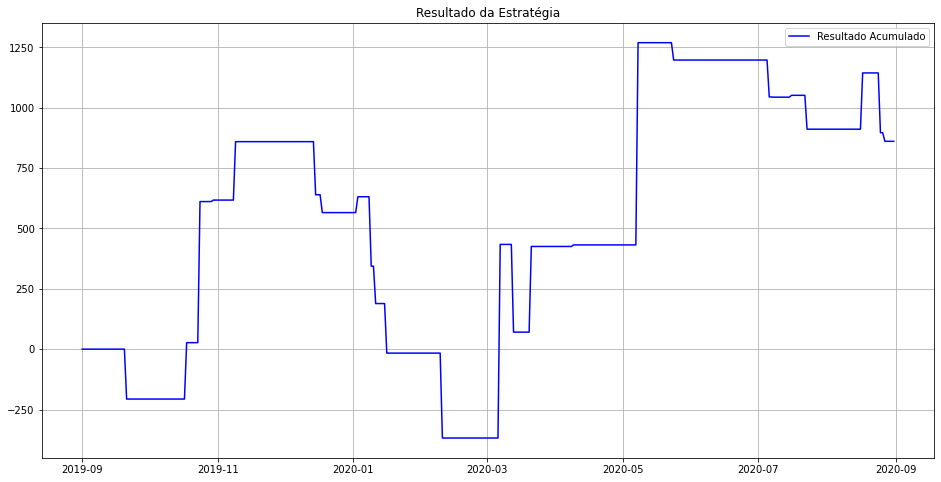

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(df.iloc[tamanho_treino:].index, acumulado[tamanho_treino:], color='blue', label='Resultado Acumulado')
plt.title("Resultado da Estratégia")
plt.legend()
plt.grid()
plt.show()

Operação com valores de MA e STD fixos baseado nas modas do modelo anterior:

In [30]:
valores_STD      = []
valores_MA       = []
valores_BB_CIMA  = []
valores_BB_BAIXO = []
operacoes        = [0] * (tamanho_total)
operacoes_compra = [0] * (tamanho_total)
operacoes_venda  = [0] * (tamanho_total)
STD              = statistics.mode(predicoes_STD)
MA               = statistics.mode(predicoes_MA)
rolagem          = df["Close"].rolling(int(MA))
atual_MA         = rolagem.mean()
atual_STD        = rolagem.std()
atual_BB_CIMA    = atual_MA + atual_STD * STD
atual_BB_BAIXO   = atual_MA - atual_STD * STD

for j in range(tamanho_treino, tamanho_total):
    atual_stop_loss = atual_STD[j] * STD

    if valores_fechamento[j - 1] < atual_BB_BAIXO[j - 1] and valores_fechamento[j] > atual_BB_BAIXO[j] and valores_fechamento[j] > valores_abertura[j]:
        if valores_fechamento[j] - valores_minima[j + 1] > atual_stop_loss:
            operacoes[j] = -atual_stop_loss
        else:
            operacoes[j] = valores_fechamento[j + 1] - valores_fechamento[j]

        operacoes_compra[j] = operacoes[j]
    elif valores_fechamento[j - 1] > atual_BB_CIMA[j - 1] and valores_fechamento[j] < atual_BB_CIMA[j] and valores_fechamento[j] < valores_abertura[j]:
        if valores_maxima[j + 1] - valores_fechamento[j] > atual_stop_loss:
            operacoes[j] = -atual_stop_loss
        else:
            operacoes[j] = valores_fechamento[j] - valores_fechamento[j + 1]

        operacoes_venda[j] = operacoes[j]

    valores_STD.append(atual_STD[j])
    valores_MA.append(atual_MA[j])
    valores_BB_CIMA.append(atual_BB_CIMA[j])
    valores_BB_BAIXO.append(atual_BB_BAIXO[j])

operacoes        = np.array(operacoes)
operacoes_compra = np.array(operacoes_compra)
operacoes_venda  = np.array(operacoes_venda)
acumulado        = np.cumsum(operacoes)
pico             = np.argmin(np.minimum.accumulate(acumulado) - acumulado)
maior_ganho      = acumulado[pico] - acumulado[np.argmin(acumulado[pico:])]
vale             = np.argmax(np.maximum.accumulate(acumulado) - acumulado)
maior_perda      = acumulado[vale] - acumulado[np.argmax(acumulado[:vale])]

contagem   = len(operacoes[operacoes != 0.])
ganhos     = len(operacoes[operacoes > 0.])
perdas     = len(operacoes[operacoes < 0.])
resultado  = np.sum(operacoes)
taxa_ganho = round(0 if contagem == 0 else ganhos/contagem, 1)

print("Modelo STD: {}".format(melhores[0][1]))
print("Modelo MA: {}".format(melhores[1][1]))
print("Total de operações: {}".format(contagem))
print("Uma operação a cada {:.1f} dias".format(tamanho_teste/contagem))
print("Operações com ganho: {}".format(ganhos))
print("Operações com perda: {}".format(perdas))
print("Taxa de ganho: {:.2%}".format(taxa_ganho))
print("Melhor ganho: {}".format(max(operacoes[operacoes > 0.])))
print("Ganho médio: {}".format(statistics.mean(operacoes[operacoes > 0.])))
print("Maior ganho acumulado: {}".format(maior_ganho))
print("Pior perda: {}".format(min(operacoes[operacoes < 0.])))
print("Perda média: {}".format(statistics.mean(operacoes[operacoes < 0.])))
print("Maior perda acumulada: {}".format(maior_perda))
print("Resultado total: {}".format(resultado))

Modelo STD: GradientBoostingClassifier(random_state=7)
Modelo MA: GradientBoostingClassifier(random_state=7)
Total de operações: 45
Uma operação a cada 8.1 dias
Operações com ganho: 17
Operações com perda: 28
Taxa de ganho: 40.00%
Melhor ganho: 801.837890625
Ganho médio: 230.6023380055147
Maior ganho acumulado: 50.582201050880826
Pior perda: -363.3408203125
Perda média: -160.9979763040745
Maior perda acumulada: -1713.008025871125
Resultado total: -587.7035904203365


Gráfico do ativo e das operações somente para o período de teste:

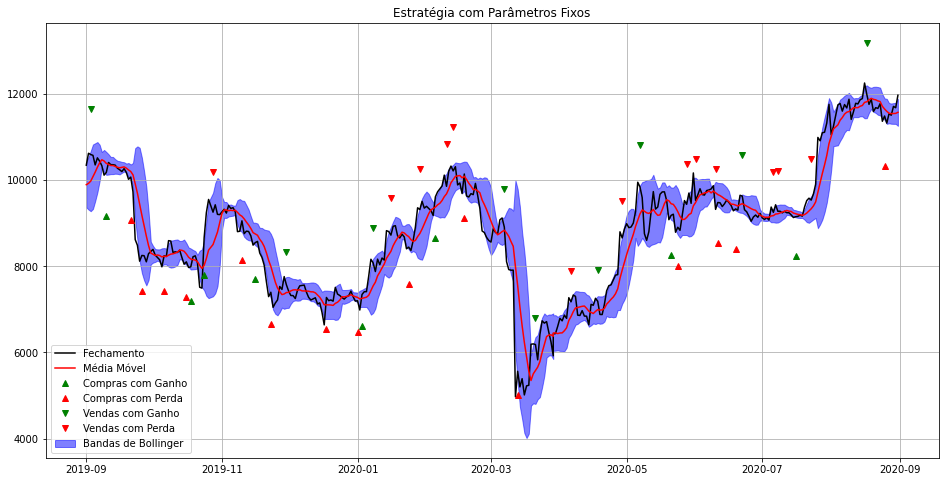

In [31]:
plt.figure(figsize=(16, 8))

plt.plot(df.iloc[tamanho_treino:].index, valores_fechamento[tamanho_treino:], color='black', label='Fechamento')
plt.plot(df.iloc[tamanho_treino:].index, valores_MA, color='red', label='Média Móvel')
plt.plot(df.loc[operacoes_compra > 0].index, valores_fechamento[operacoes_compra > 0] * .9, '^', color='green', label='Compras com Ganho')
plt.plot(df.loc[operacoes_compra < 0].index, valores_fechamento[operacoes_compra < 0] * .9, '^', color='red', label='Compras com Perda')
plt.plot(df.loc[operacoes_venda > 0].index, valores_fechamento[operacoes_venda > 0] * 1.1, 'v', color='green', label='Vendas com Ganho')
plt.plot(df.loc[operacoes_venda < 0].index, valores_fechamento[operacoes_venda < 0] * 1.1, 'v', color='red', label='Vendas com Perda')
plt.fill_between(df.iloc[tamanho_treino:].index, valores_BB_BAIXO, valores_BB_CIMA, color='blue', alpha=0.5, label='Bandas de Bollinger')

plt.title("Estratégia com Parâmetros Fixos")
plt.legend()
plt.grid()
plt.show()

Gráfico com o resultado acumulado:

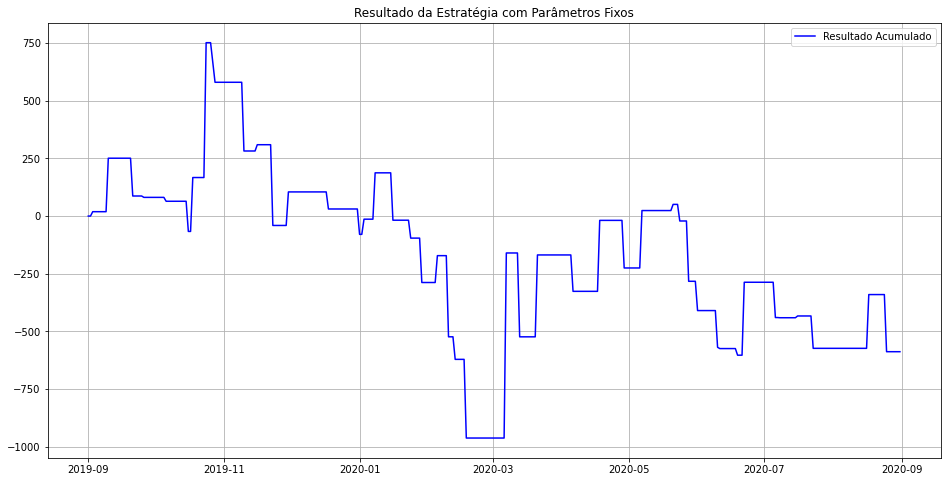

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(df.iloc[tamanho_treino:].index, acumulado[tamanho_treino:], color='blue', label='Resultado Acumulado')
plt.title("Resultado da Estratégia com Parâmetros Fixos")
plt.legend()
plt.grid()
plt.show()